<table style="width:100%">
  <tr>
    <th> <img src=".\..\img\logo_EPM_UNIOVI_CabeceroWEB.gif" alt="Uniovi & EP Mieres logos" title="Uniovi & EP Mieres logos" /></th>
    <th><font color=brown>Procesamiento de imágenes de Sensores Aerotransportados y Satélite</font>
         </font></th> 
    <th><font color=green>Universidad de Oviedo.                      Ingeniería en Geomática</font>         sgcortes@uniovi.es</th>
  </tr>
</table>

## Modificación lineal del contraste y clipping
Es frecuente que sea necesario mejorar el contraste de una imagen a causa de la repuesta deficiente del mismo en zonas oscuras y muy claras de la escena o a defectos en la exposición. En muchas ocasiones la imagen se presenta un bajo rango dinámico. una manera de corregir este problema y conseguir que el histograma ocupe la totalidad del rango de niveles digitales disponible es definiendo una transformación recta que aplique el intervalo de entrada [NDinput mínimo, NDinput maximo] sobre el intervalo de salida total para la profundidad de bits elegida en la imagen (frecuentemente 8 bits=256 niveles).

La transformación lineal se puede en este caso implementar de modo automático empleando la función **exposure.rescale_intensity()** a la que se puede suminstrar un intervalo de entrada y salida de niveles digitales. 

### Expansión lineal del histograma

In [1]:
import skimage
from skimage import exposure, data, img_as_float, io
import numpy as np
import matplotlib.pyplot as plt
colo = io.imread('B8_colorado.tif')
colo = img_as_float(colo)
print(colo.shape)
io.imshow(colo)
plt.title('Colorado (Landsat). Grayscale')
plt.axis('off')
# Valores máximos y mínimos de la imagen
print('ND Máximo= ', colo.max())
print('ND Mínimo= ', colo.min())

(673, 622)
ND Máximo=  0.6475165941863127
ND Mínimo=  0.06283665217059586


(0, 1)

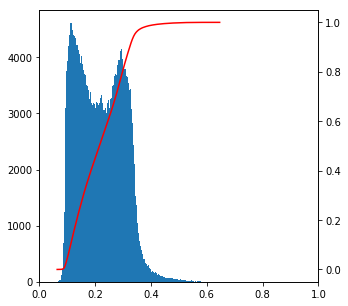

In [2]:
# Histograma
fig2 = plt.figure(figsize=(5,5)) # controla el tamaño de la figura y los ejes
m = plt.hist(colo.ravel(),bins=256)
img_cdf, bins = skimage.exposure.cumulative_distribution(colo, 256)
ax_cdf = plt.twinx()
ax_cdf.plot(bins,img_cdf, color='red')
ax_cdf.set_xlim(0,1)

En la histograma anterior puede verse como el rango dinámico es muy pequeño y se desperdician muchos valores de niveles digitales. Podemos expandir el rango mediante la función **rescale_intensity**. 

ND Máximo=  1.0
ND Mínimo=  0.0


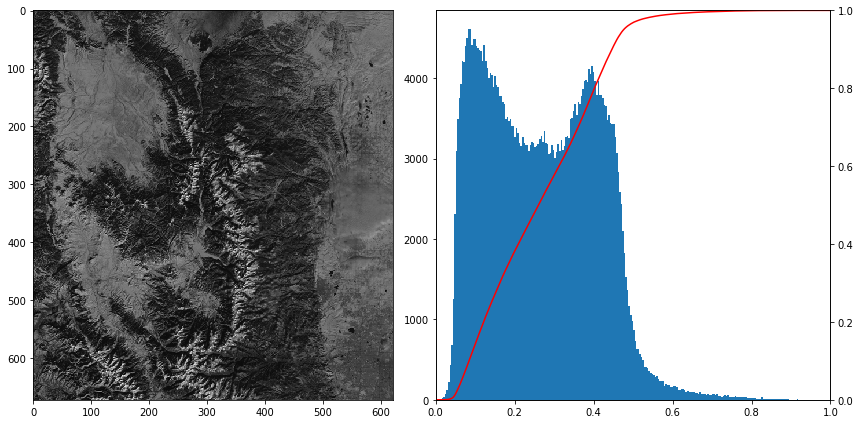

In [3]:
fig3=plt.figure(figsize=(12,6))
colo_rescaled = exposure.rescale_intensity(colo)
plt.subplot(1,2,1)
io.imshow(colo_rescaled)
plt.subplot(1,2,2)
m_rescaled = plt.hist(colo_rescaled.ravel(),bins=256)
img_cdf, bins = skimage.exposure.cumulative_distribution(colo_rescaled, 256)
ax_cdf = plt.twinx()
ax_cdf.plot(bins,img_cdf, color='red')
ax_cdf.set_xlim(0,1)
ax_cdf.set_ylim(0,1)
plt.tight_layout()

# Valores máximos y mínimos de la imagen
print('ND Máximo= ', colo_rescaled.max())
print('ND Mínimo= ', colo_rescaled.min())

Hemos mejorado el rango dinámico, pero aún vemos que tenemos una zona a la derecha del histograma con muy pocas frecuencias de píxeles. En general estas zonas casi blancas con muy pocos píxeles (que también pueden aparecer en  la parte opuesta con las sombras) se deben a la respuesta del sensor que produce unos píxeles con niveles digitales anormalmente altos. Vamos entonces a emplear lo que se denomina el **__Clipping__**

0.10247959105821317 0.342046234836347


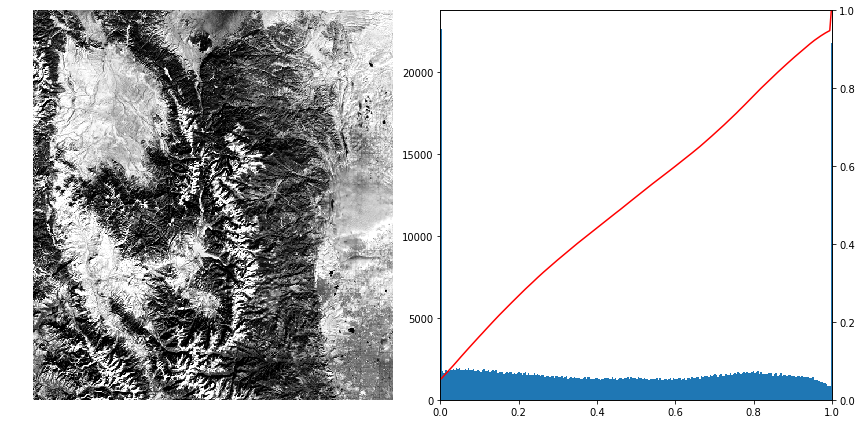

In [4]:
fig4=plt.figure(figsize=(12,6))
pmin, pmax = np.percentile(colo, (5,95))
print(pmin,pmax)
colo_clipped = exposure.rescale_intensity(colo, in_range=(pmin,pmax))
plt.subplot(121)
io.imshow(colo_clipped, cmap='gray')
plt.axis('off')
plt.subplot(122)
m_clipped = plt.hist(colo_clipped.ravel(),bins=256)
img_cdf, bins = skimage.exposure.cumulative_distribution(colo_clipped, 256)
ax_cdf = plt.twinx()
ax_cdf.plot(bins,img_cdf, color='red')
ax_cdf.set_xlim(0,1)
ax_cdf.set_ylim(0,1)
plt.tight_layout()


Con la transformación anterior, **clipping** estamos aplicando el intervalo de ND´s entre los percentiles 2% y 98% al rango completo de ND´s disponible para la imagen. El histograma cambia radicalmente de forma pasando a asemejarse a un histograma uniforme y el histograma acumulado casi a la recta a 45º. La imagen tiene ahora mucho mejor contraste. Es interesante comparar ahora las funciones de trasferencia de la simple **expansión lineal** del histograma con la del **clipping** (limitada por los valores de los percentiles).

Text(0.3,0.2,'$NDmax_{in}: 0.35$')

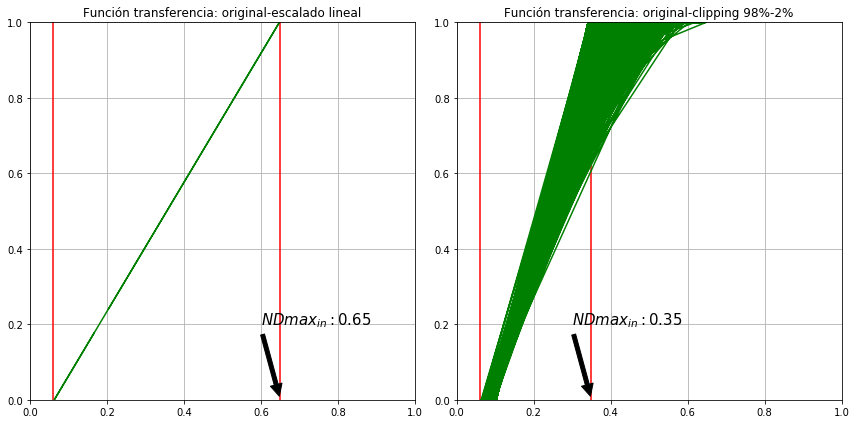

In [5]:
fig5=plt.figure(figsize=(12,6))
plt.subplot(121)
ax_transf1 = plt.plot(colo.ravel(),colo_rescaled.ravel(),color = 'green')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.vlines([0.06, 0.65], 0, 1, colors='r')
plt.title('Función transferencia: original-escalado lineal')
plt.annotate('$NDmax_{in}: 0.65$', xy=(0.65, 0), xytext=(0.6, 0.2),
             arrowprops=dict(facecolor='black',shrink=0.05),fontsize=15)
plt.subplot(122)
ax_transf2 = plt.plot(colo.ravel(),colo_clipped.ravel(),color = 'green')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.title('Función transferencia: original-clipping 98%-2%')
plt.tight_layout()
plt.vlines([0.06, 0.35], 0, 1, colors='r')
plt.annotate('$NDmax_{in}: 0.35$', xy=(0.35, 0), xytext=(0.3, 0.2),
             arrowprops=dict(facecolor='black',shrink=0.05),fontsize=15)

Nótese que la pendiente de las dos rectas (en la figura izquierda nos referimos al límite izquierdo de la región verde) delimitada por las líneas verticales rojas es el rango de ND's de entrada que resulta explandido en todo el rango de salida.

